## Initialization and setup

In [2]:
# General
import os
import sys
import subprocess
import copy

# Dataset management
import datalad.api as dl

# Data handling
import pandas as pd
import numpy as np
import nibabel as nib
import scipy.io as sio

# BIDS dataset handling
from bids import BIDSLayout

# Network / Graph
!pip install pygsp
import pygsp
import networkx as nx

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.pylab as pl
from matplotlib.colors import LogNorm
import nilearn
from nilearn import plotting, image, datasets

import scipy.io
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, Normalize
from matplotlib.ticker import MaxNLocator

  Using cached PyGSP-0.5.1-py2.py3-none-any.whl (1.8 MB)


In [4]:
 mat = scipy.io.loadmat('/home/jovyan/shared/harmonics/nhw2022-network-harmonics-data.mat')

In [5]:
key_list = list(mat.keys())
key_list

['__header__',
 '__version__',
 '__globals__',
 'age',
 'nets',
 'None',
 'yeoLabs',
 '__function_workspace__']

In [6]:
adj_mat=mat['nets']

<AxesSubplot:>

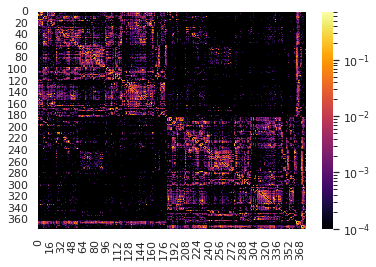

In [7]:
# Create color map to handle zeros with log visualization
custom_cmap = copy.copy(plt.cm.get_cmap("inferno"))
# Copy the default cmap (0,0,0.5156)
custom_cmap.set_bad((0, 0, 0))
sns.heatmap(adj_mat[:,:,0], cmap = custom_cmap, norm=LogNorm())


In [18]:
# np.fill_diagonal(all_subj, 0)  # PyGSP does not support self-loops
# G_fd = pygsp.graphs.Graph(all_subj)  # PyGSP graph
# G_fd.compute_laplacian(lap_type="normalized")
# G_fd.compute_fourier_basis()  # compute connectome harmonics

# # Display the shape of the matrix
# print(G_fd.U.shape)

# # Check if connected
# print(G_fd.is_connected())



ValueError: All dimensions of input must be of equal length

## Age effects on the connectivity calculations
Done through analyzing entropy of each eigenvector or Fourier Basis or harmonics which comes from performing eigendecomposition of connectivity matrices

In [8]:
all_subj = adj_mat
harmonics=np.zeros(all_subj.shape)
eigval=np.zeros((all_subj.shape[0],all_subj.shape[2]))

In [9]:
# Compute harmonics for each and every subject
for i in range(all_subj.shape[2]):
        subject = all_subj[:,:,i]
        np.fill_diagonal(subject, 0)  # PyGSP does not support self-loops

        G_fd = pygsp.graphs.Graph(subject)  # PyGSP graph
        G_fd.compute_laplacian(lap_type="normalized")
        G_fd.compute_fourier_basis()  # compute connectome harmonics
    
        harmonics[:,:,i]=G_fd.U # Fourier basis (eigenvectors of the Laplacian).
        eigval[:,i] = G_fd.e # The degree (the number of neighbors) of each node.

/srv/conda/envs/notebook/lib/python3.7/site-packages/pygsp/graphs/graph.py:496: RuntimeWarning: divide by zero encountered in power
  d = np.power(self.dw, -0.5)


In [10]:
# Entropy calculation
ceil_h = 40 # maximum number of harmonics we want
num_subj = harmonics.shape[2]
from scipy.stats import entropy
def f(x):
    return int(x)
int_vec = np.vectorize(f) # vectorize the int function for getting unique counts
entropia=np.zeros((num_subj,ceil_h)) # first ceil_h harmonics
for j in range(ceil_h):
    for subj in range(num_subj):
        values, counts = np.unique(int_vec(harmonics[:,j,subj]*100.), return_counts=True)
        entropia[subj,j] = entropy(counts, base=2)
        
print("done")

done


In [11]:
entropia.shape

(594, 40)

,Age,a
0,24,3.824089
1,28,4.129179
2,28,3.899605
3,23,4.135117
4,22,4.105387
...,...,...
589,79,3.896250
590,79,3.546828
591,79,3.384700
592,80,3.316217


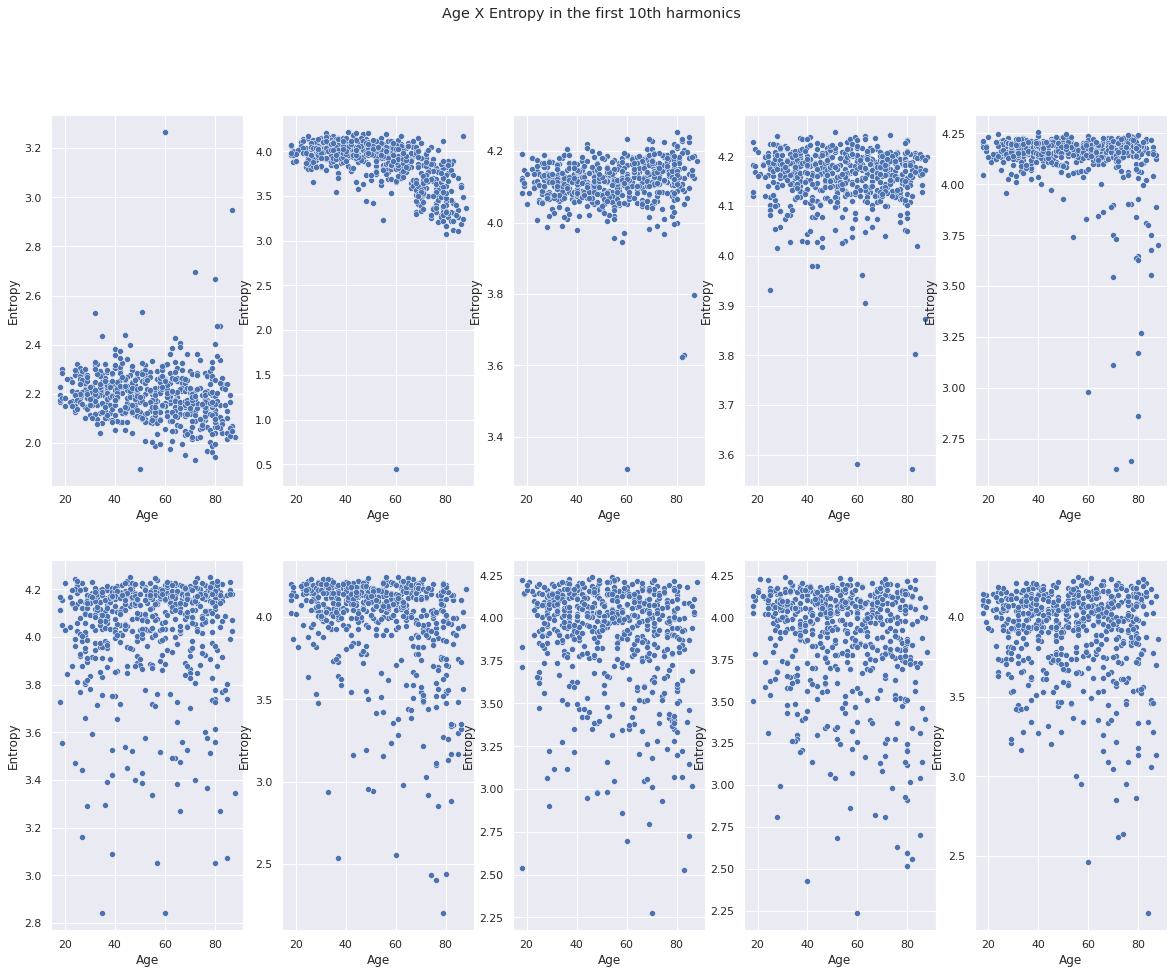

In [14]:
import seaborn as sns
import time
sns.set(style="darkgrid")
age=mat['age']
harm_range=10 # range of harmonics that will be plotted

#df=pd.DataFrame(age,columns=['Age'])
df=pd.DataFrame(mat['age'],columns=['Age'])
fig, axes = plt.subplots(2, 5, figsize=(20,15))
fig.suptitle('Age X Entropy in the first 10 harmonics')

rows=[0,0,0,0,0,1,1,1,1,1]
columns=[0,1,2,3,4,0,1,2,3,4]

for i in range(harm_range):
    
    df['Entropy']= entropia[:,i]
    sns.scatterplot(ax=axes[rows[i],columns[i]],data=df, x='Age', y='Entropy')

plt.savefig("Entrophy_age.png")


eigenvalue eigenvector 0


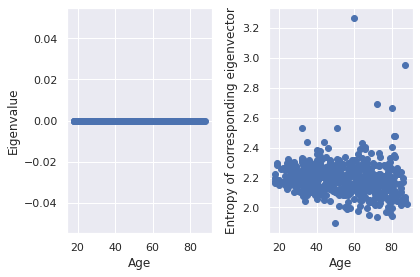

eigenvalue eigenvector 1


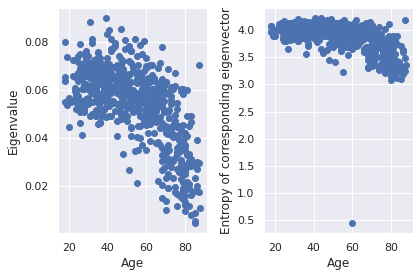

eigenvalue eigenvector 2


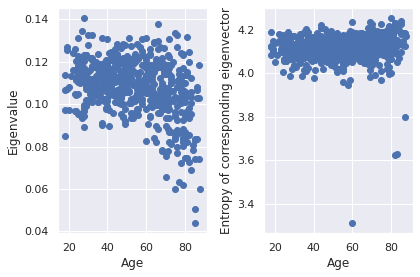

eigenvalue eigenvector 3


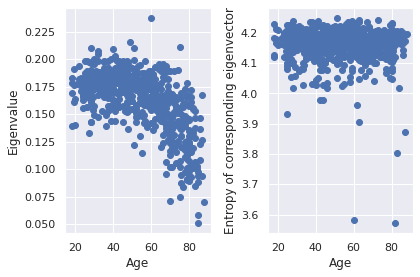

eigenvalue eigenvector 4


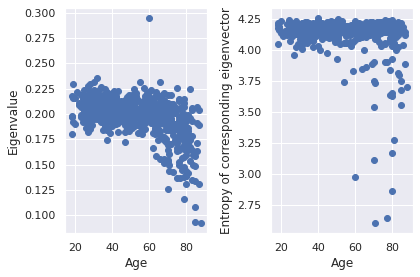

eigenvalue eigenvector 5


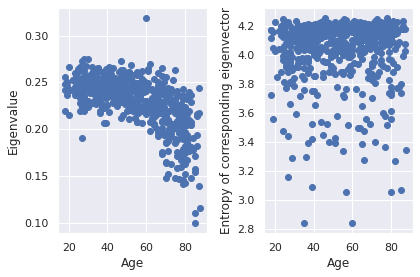

eigenvalue eigenvector 6


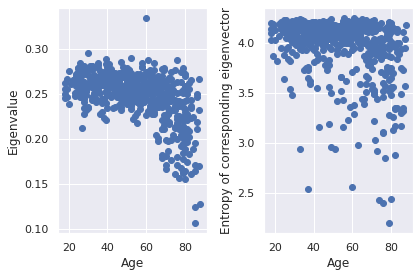

eigenvalue eigenvector 7


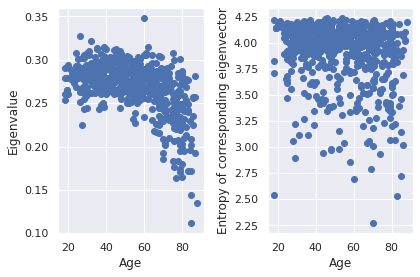

eigenvalue eigenvector 8


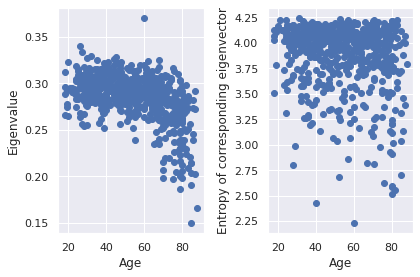

eigenvalue eigenvector 9


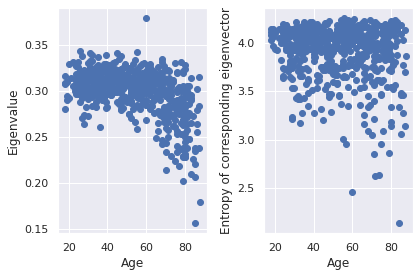

eigenvalue eigenvector 10


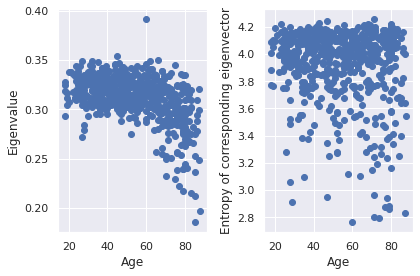

eigenvalue eigenvector 11


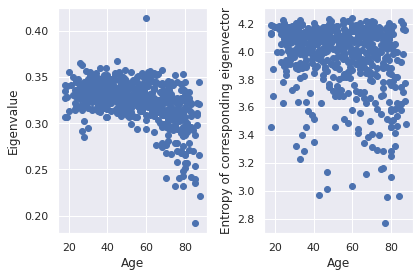

eigenvalue eigenvector 12


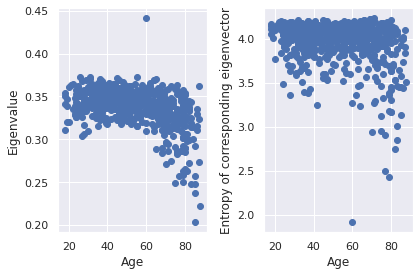

eigenvalue eigenvector 13


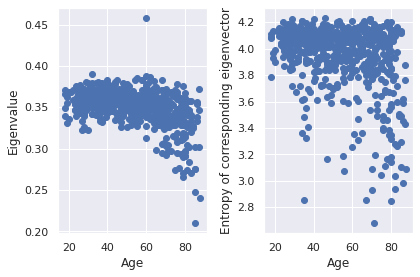

eigenvalue eigenvector 14


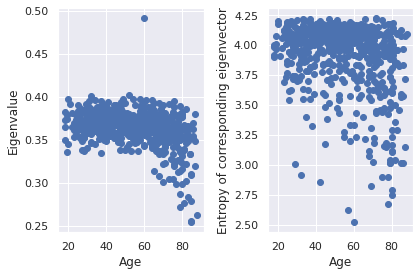

eigenvalue eigenvector 15


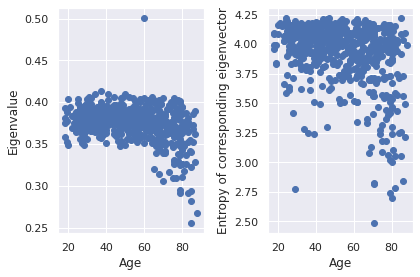

eigenvalue eigenvector 16


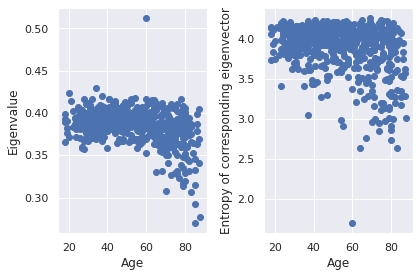

eigenvalue eigenvector 17


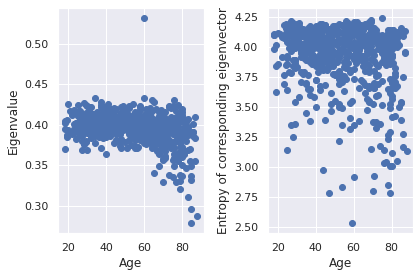

eigenvalue eigenvector 18


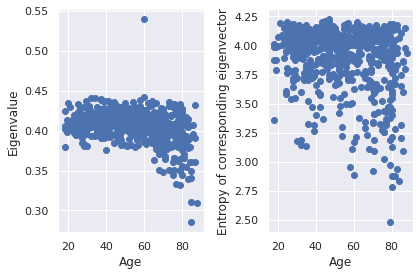

eigenvalue eigenvector 19


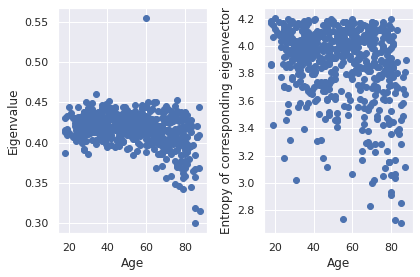

done


<Figure size 432x288 with 0 Axes>

In [18]:
shannon1=np.zeros(594)
shannon2=np.zeros(594)
for harm in range(0,20):
    x = age
    for subject in range(594):
        shannon1[subject]=eigval[harm,subject]
        shannon2[subject]=entropia[subject,harm]
        
    print("eigenvalue","eigenvector",harm)
    plt.subplot(1, 2, 1)
    plt.scatter(x,shannon1)
    #plt.title('eigenvalues')
    plt.xlabel('Age')
    plt.ylabel('Eigenvalue')
    plt.subplot(1, 2, 2)
    plt.scatter(x,shannon2)
    #plt.title('entropy of the eigenvector')
    plt.xlabel('Age')
    plt.ylabel('Entropy of corresponding eigenvector')
    plt.tight_layout()
    plt.show()
print("done")

plt.savefig("Entropy_eigvector.pdf")

In [19]:
eigval.shape


(376, 594)

In [20]:
combine_age = np.hstack((mat["age"], entropia))
means = {}
unique_age = np.unique(combine_age[:,0])
binned_age = np.histogram_bin_edges(unique_age, bins=int(np.floor(len(unique_age)/10)))
for i in binned_age:
    tmp = combine_age[np.where(combine_age[:,0] == i),1:]
    # print(tmp.shape)
    if tmp.shape[1] > 1:
        means[i] = np.mean(np.squeeze(tmp),axis=0)
    else:
        means[i] = np.squeeze(tmp)
# print(means)
means_df = pd.DataFrame.from_dict(means)
means_df

,18.0,28.0,38.0,48.0,58.0,68.0,78.0,88.0
0,2.190597,2.214427,2.185912,2.194542,2.180803,2.126927,2.166877,2.025895
1,4.020048,3.990705,3.908648,3.969733,3.870936,3.704488,3.587652,3.363131
2,4.129798,4.095535,4.093405,4.122326,4.119027,4.128757,4.109203,4.171173
3,4.164489,4.167078,4.169711,4.184664,4.152177,4.162839,4.161524,4.197841
4,4.161102,4.163736,4.170078,4.183347,4.158057,4.180448,4.185922,3.704317
5,4.044515,3.984323,4.085739,4.086718,4.064293,4.109606,4.085613,3.344643
6,4.113684,4.053836,3.861082,3.958358,4.032175,4.037466,4.034093,4.171859
7,3.574887,3.921374,3.837706,3.815388,3.736390,3.776467,3.769396,4.208419
8,3.931425,3.917823,3.820104,3.896491,3.743996,4.012732,3.917672,3.796450
9,4.088518,3.946246,4.088390,3.889001,3.913210,3.833992,3.997554,3.862038


In [21]:
print(entropia.shape)
print(eigval.shape)
print(len(binned_age))

(594, 40)
(376, 594)
8


In [22]:
# Calculate the mean entropy for each harmonics group by age which are binned into 10 year bins
combine_age = np.hstack((mat["age"], entropia))
combine_age_w_eig = np.vstack((mat["age"].T, eigval)).T
means_eig = {}
means_ent = {}
unique_age = np.unique(combine_age[:,0])
binned_age = np.histogram_bin_edges(unique_age, bins=int(np.floor(len(unique_age)/10)))
for i in range(len(binned_age)):
    if i != len(binned_age)-1: 
        # Logical and operator usage REF: https://stackoverflow.com/questions/13869173/numpy-find-index-of-the-elements-within-range
        tmp_ent = combine_age[np.where(np.logical_and(combine_age[:,0] >= binned_age[i], combine_age[:,0] < binned_age[i+1])),1:]
        tmp_eig = combine_age_w_eig[np.where(np.logical_and(combine_age_w_eig[:,0] >= binned_age[i], combine_age_w_eig[:,0] < binned_age[i+1])),1:]
        # print(tmp_ent.shape) # visualize the shape of how many subjects are in which bin (second dim)
        # print(tmp_eig.shape)
        # print(i)
        if tmp_ent.shape[1] > 1:
            means_ent[i] = np.mean(np.squeeze(tmp_ent),axis=0)
        else:
            means_ent[i] = np.squeeze(tmp_ent)
        if tmp_eig.shape[1] > 1:
            means_eig[i] = np.mean(np.squeeze(tmp_eig),axis=0)
        else:
            means_eig[i] = np.squeeze(tmp_eig)
    else:
        tmp_ent = combine_age[np.where(combine_age[:,0] >= binned_age[i]),1:]
        tmp_eig = combine_age_w_eig[np.where(combine_age_w_eig[:,0] >= binned_age[i]),1:]
        print(tmp_ent.shape) # visualize the shape of how many subjects are in which bin (second dim)
        if tmp_ent.shape[1] > 1:
            means_ent[i] = np.mean(np.squeeze(tmp_ent),axis=0)
        else:
            means_ent[i] = np.squeeze(tmp_ent)
        if tmp_eig.shape[1] > 1:
            means_eig[i] = np.mean(np.squeeze(tmp_eig),axis=0)
        else:
            means_eig[i] = np.squeeze(tmp_eig)
    
means_df_ent = pd.DataFrame.from_dict(means_ent)
means_df_eig = pd.DataFrame.from_dict(means_eig)
display(means_df_ent)
display(means_df_eig)

(1, 1, 40)


,0,1,2,3,4,5,6,7
0,2.215753,2.208205,2.206409,2.179836,2.212351,2.154967,2.172814,2.025895
1,3.981882,4.010463,4.006485,3.947156,3.867963,3.677966,3.523752,3.363131
2,4.115388,4.107882,4.112262,4.104016,4.118994,4.130831,4.116278,4.171173
3,4.161248,4.166625,4.151280,4.164775,4.153081,4.161745,4.147322,4.197841
4,4.160547,4.157536,4.163204,4.155700,4.138273,4.100785,4.050155,3.704317
5,4.008399,4.022303,4.054559,4.036563,4.046233,4.061939,4.026306,3.344643
6,4.100125,4.042206,4.054086,3.999316,3.989831,3.861672,3.779710,4.171859
7,3.947309,3.973388,3.931717,3.926433,3.873248,3.826952,3.749649,4.208419
8,3.985118,3.910544,3.914300,3.887135,3.861652,3.874021,3.691049,3.796450
9,4.017533,3.896851,3.946040,3.893565,3.926258,3.835677,3.843543,3.862038


,0,1,2,3,4,5,6,7
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.061314,0.062759,0.063292,0.058258,0.055758,0.040912,0.029692,0.010507
2,0.111729,0.111836,0.111412,0.109416,0.109873,0.102449,0.095564,0.059838
3,0.173284,0.176695,0.178151,0.170387,0.167918,0.142782,0.123633,0.070103
4,0.205960,0.206182,0.203264,0.200847,0.200515,0.186042,0.173314,0.092378
...,...,...,...,...,...,...,...,...
371,1.483102,1.488580,1.487954,1.483808,1.491616,1.486780,1.483287,1.503219
372,1.495913,1.502847,1.501714,1.499888,1.506597,1.502782,1.497509,1.510282
373,1.514855,1.518611,1.518699,1.517678,1.523416,1.518817,1.512988,1.513391
374,1.545536,1.543728,1.544130,1.544715,1.549103,1.541713,1.534635,1.520812


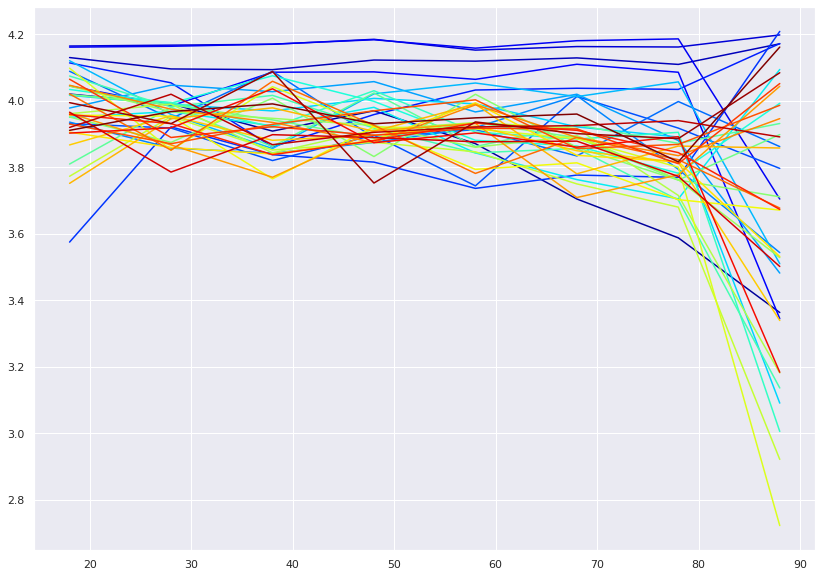

In [23]:
# plot of age versus entropy for each harmonic
age_unique = np.unique(mat["age"])
fig, ax = plt.subplots(figsize=(14, 10))
# Color gradient REF: https://stackoverflow.com/questions/38208700/matplotlib-plot-lines-with-colors-through-colormap
n = ceil_h
colors = pl.cm.jet(np.linspace(0,1,n))
for i in range(1,ceil_h):
    ax.plot(binned_age,means_df.loc[i], label='har= %s' % str(i+1), c=colors[i])
# ax.legend()

## Visualization Plots 
### (Note: Exclude the last bin since only one sample is inside that bin)

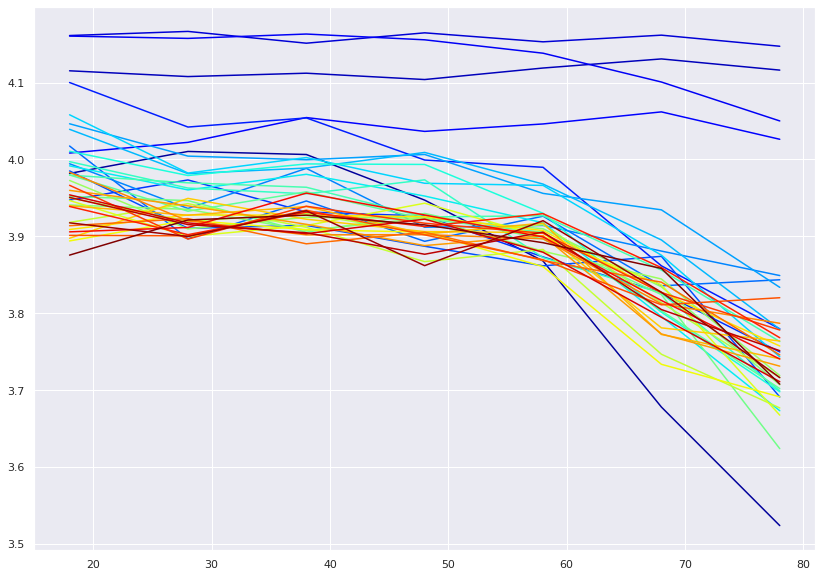

In [24]:
# plot of age versus entropy for each harmonic
age_unique = np.unique(mat["age"])
fig, ax = plt.subplots(figsize=(14, 10))
# Color gradient REF: https://stackoverflow.com/questions/38208700/matplotlib-plot-lines-with-colors-through-colormap
n = ceil_h
colors = pl.cm.jet(np.linspace(0,1,n))
for i in range(1,ceil_h):
    ax.plot(binned_age[:7],means_df_ent.iloc[i,:7], label='har= %s' % str(i+1), c=colors[i])

IndexError: single positional indexer is out-of-bounds

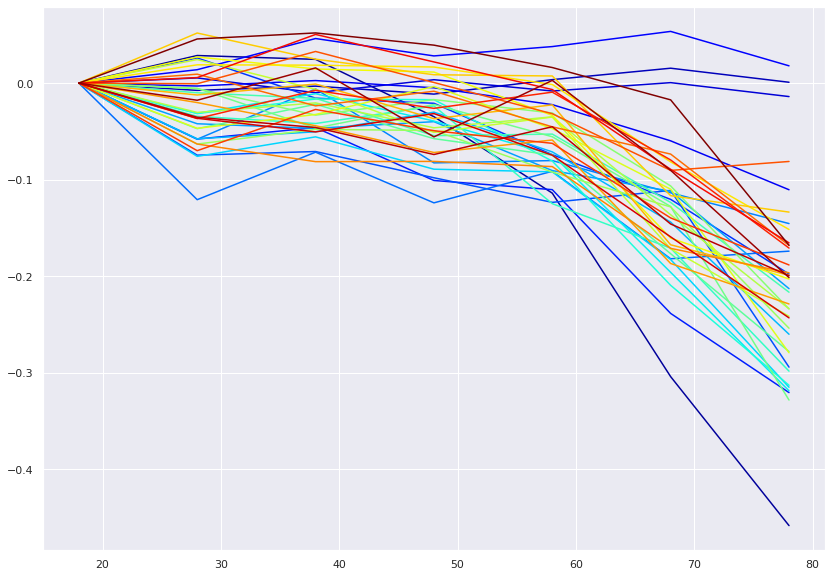

In [25]:
# plot of age versus difference of entropy values between first index and other indices for each harmonic
fig, ax = plt.subplots(figsize=(14, 10))
# Color gradient REF: https://stackoverflow.com/questions/38208700/matplotlib-plot-lines-with-colors-through-colormap
n = ceil_h
ceil_h = 200
colors = pl.cm.jet(np.linspace(0,1,n))
for i in range(1,ceil_h):
    diff_ent = means_df_ent.iloc[i,:7] - means_df_ent.iloc[i,0]
    ax.plot(binned_age[:7],diff_ent, label='har= %s' % str(i+1), c=colors[i])

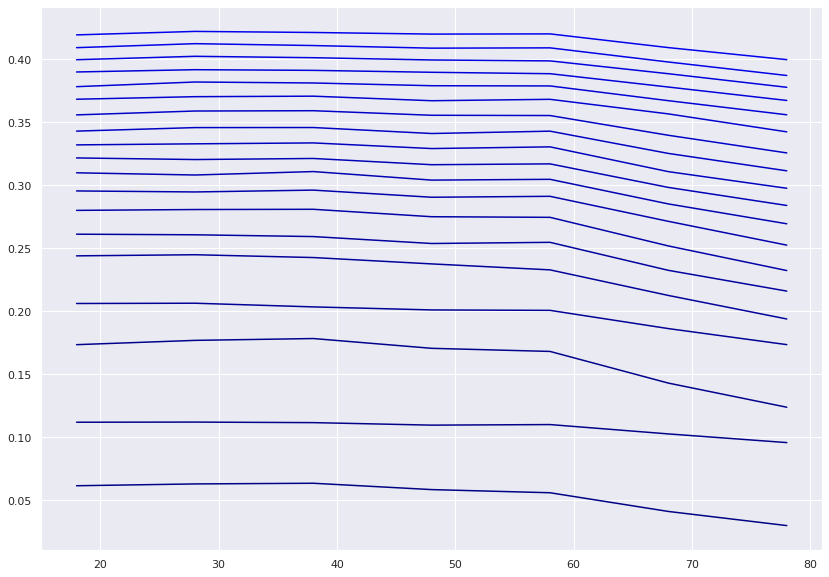

In [26]:
# plot of age versus eigenvalue for each harmonic
fig, ax = plt.subplots(figsize=(14, 10))
# Color gradient REF: https://stackoverflow.com/questions/38208700/matplotlib-plot-lines-with-colors-through-colormap
n = ceil_h
ceil_h = 20
colors = pl.cm.jet(np.linspace(0,1,n))
for i in range(1,ceil_h):
    ax.plot(binned_age[:7],means_df_eig.iloc[i,:7], label='har= %s' % str(i+1), c=colors[i])

IndexError: index 20 is out of bounds for axis 0 with size 20

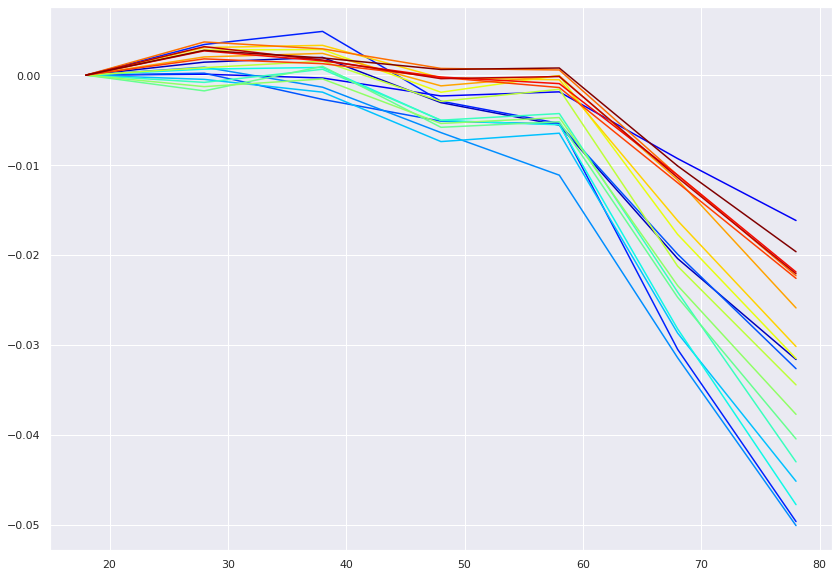

In [27]:
# plot of age versus difference of eigenvalue between first index and other indices for each harmonic
fig, ax = plt.subplots(figsize=(14, 10))
# Color gradient REF: https://stackoverflow.com/questions/38208700/matplotlib-plot-lines-with-colors-through-colormap
n = ceil_h
ceil_h = 200
colors = pl.cm.jet(np.linspace(0,1,n))
for i in range(1,ceil_h):
    diff_eig = means_df_eig.iloc[i,:7] - means_df_eig.iloc[i,0]
    # ax.plot(binned_age[:7],means_df_eig.iloc[i,:7], label='har= %s' % str(i+1), c=colors[i])
    ax.plot(binned_age[:7],diff_eig, label='har= %s' % str(i+1), c=colors[i])

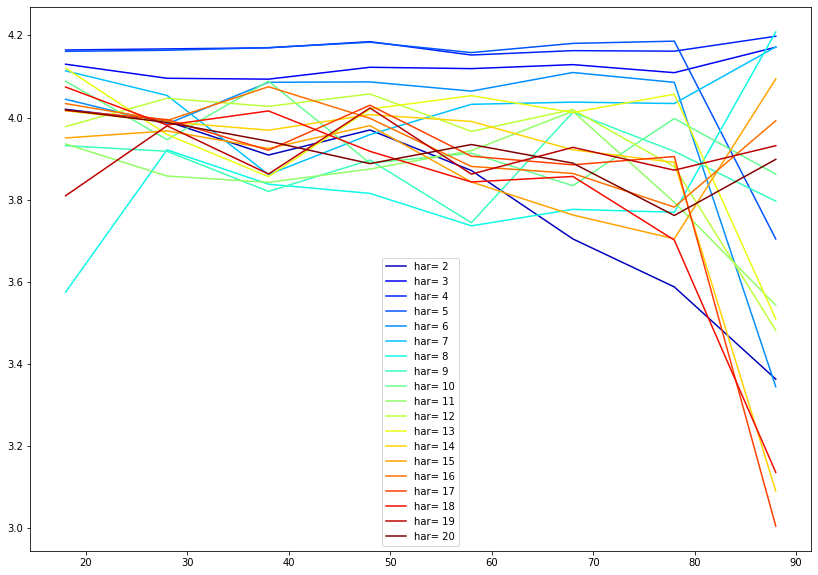

In [144]:
# age_unique = np.unique(mat["age"])
# # fig, ax = plt.figure(figsize=(12,10))
# fig, ax = plt.subplots(figsize=(14, 10))
# # Color gradient REF: https://stackoverflow.com/questions/38208700/matplotlib-plot-lines-with-colors-through-colormap
# import matplotlib.pylab as pl
# n = ceil_h
# colors = pl.cm.jet(np.linspace(0,1,n))
# for i in range(1,ceil_h):
#     ax.plot(binned_age,means_df.loc[i], label='har= %s' % str(i+1), c=colors[i])
# ax.legend()

<AxesSubplot:>

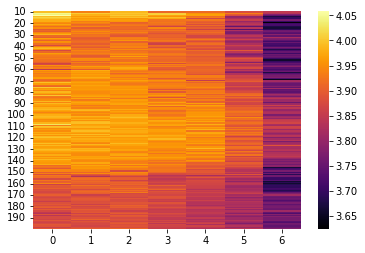

In [52]:
# heatmap visualization for raw entropy measures from 11th harmonic onwards
# Create color map to handle zeros with log visualization
custom_cmap = copy.copy(plt.cm.get_cmap("inferno"))
# Copy the default cmap (0,0,0.5156)
custom_cmap.set_bad((0, 0, 0))
sns.heatmap(means_df_ent.iloc[10:,:7], cmap = custom_cmap)

<AxesSubplot:>

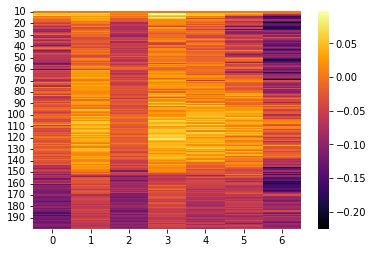

In [53]:
# heatmap visualization for difference of entropy between first and other indices from 11th harmonic onwards
# Create color map to handle zeros with log visualization
custom_cmap = copy.copy(plt.cm.get_cmap("inferno"))
# Copy the default cmap (0,0,0.5156)
custom_cmap.set_bad((0, 0, 0))
sns.heatmap(means_df_ent.iloc[10:,:7] - means_df_ent.iloc[10,:7], cmap = custom_cmap)

<AxesSubplot:>

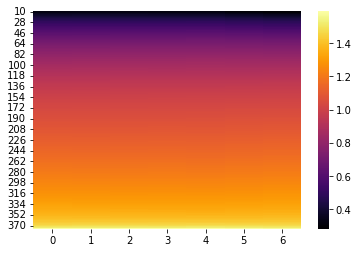

In [54]:
# heatmap visualization for raw entropy measures from 11th harmonic onwards
# Create color map to handle zeros with log visualization
custom_cmap = copy.copy(plt.cm.get_cmap("inferno"))
# Copy the default cmap (0,0,0.5156)
custom_cmap.set_bad((0, 0, 0))
sns.heatmap(means_df_eig.iloc[10:,:7], cmap = custom_cmap)

<AxesSubplot:>

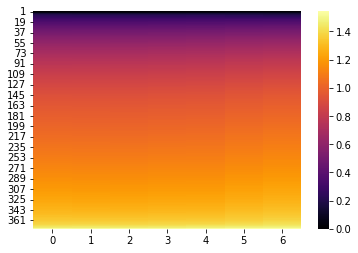

In [56]:
# heatmap visualization for difference of eigenvalues between first and other indices from 11th harmonic onwards
# Create color map to handle zeros with log visualization
custom_cmap = copy.copy(plt.cm.get_cmap("inferno"))
# Copy the default cmap (0,0,0.5156)
custom_cmap.set_bad((0, 0, 0))
sns.heatmap(means_df_eig.iloc[1:,:7] - means_df_eig.iloc[1,:7], cmap = custom_cmap)

## Scratch paper (not used)

In [65]:
# Entropy calculation ==> Ramon's code
from scipy.stats import entropy
entropia=np.zeros(594)
for subject in range(594):
    array=np.zeros(376*376,dtype=int)
    cont=-1
    add=0
    for xx in range(376):
        for yy in range(0,376):
            cont=cont+1
            array[cont]=int(harmonics[xx,yy,subject]*100.)
    # print(array.shape)
    values,counts = np.unique(array,return_counts=True)
    entropia[subject] = entropy(counts,base=2)
    #print(subject,"-------------------------------------------",counts.size)
print("done")

(141376,)
(141376,)
(141376,)
(141376,)
(141376,)
(141376,)
(141376,)
(141376,)
(141376,)
(141376,)
(141376,)
(141376,)
(141376,)
(141376,)
(141376,)
(141376,)
(141376,)
(141376,)
(141376,)
(141376,)
(141376,)
(141376,)
(141376,)
(141376,)
(141376,)
(141376,)
(141376,)
(141376,)
(141376,)
(141376,)
(141376,)
(141376,)
(141376,)
(141376,)
(141376,)
(141376,)
(141376,)
(141376,)
(141376,)
(141376,)
(141376,)
(141376,)
(141376,)
(141376,)
(141376,)
(141376,)
(141376,)
(141376,)
(141376,)
(141376,)
(141376,)
(141376,)
(141376,)
(141376,)
(141376,)
(141376,)
(141376,)
(141376,)
(141376,)
(141376,)
(141376,)
(141376,)
(141376,)
(141376,)
(141376,)
(141376,)
(141376,)
(141376,)
(141376,)
(141376,)
(141376,)
(141376,)
(141376,)
(141376,)
(141376,)
(141376,)
(141376,)
(141376,)
(141376,)
(141376,)
(141376,)
(141376,)
(141376,)
(141376,)
(141376,)
(141376,)
(141376,)
(141376,)
(141376,)
(141376,)
(141376,)
(141376,)
(141376,)
(141376,)
(141376,)
(141376,)
(141376,)
(141376,)
(141376,)
(141376,)


KeyboardInterrupt: 

In [39]:
combine_age = np.vstack((np.squeeze(mat["age"]), entropia))
combine_age.shape
combine_age[0,:]

array([24., 28., 28., 23., 22., 25., 18., 25., 28., 25., 29., 28., 19.,
       25., 25., 19., 28., 26., 24., 27., 24., 28., 23., 22., 27., 28.,
       27., 21., 18., 18., 25., 28., 19., 26., 23., 27., 24., 23., 20.,
       28., 18., 26., 28., 24., 26., 25., 27., 26., 26., 26., 20., 25.,
       27., 27., 24., 31., 35., 36., 35., 30., 31., 31., 29., 32., 34.,
       34., 29., 37., 34., 37., 29., 32., 34., 29., 31., 30., 37., 34.,
       33., 36., 35., 34., 33., 34., 29., 37., 33., 31., 35., 30., 29.,
       28., 32., 37., 32., 36., 35., 33., 35., 33., 37., 34., 37., 37.,
       37., 38., 28., 29., 36., 31., 35., 29., 37., 32., 36., 34., 37.,
       29., 35., 36., 34., 32., 31., 33., 30., 36., 35., 32., 32., 32.,
       33., 37., 32., 37., 34., 37., 34., 32., 35., 37., 38., 35., 37.,
       38., 29., 30., 31., 32., 38., 36., 36., 45., 42., 42., 47., 40.,
       42., 48., 41., 39., 46., 47., 47., 44., 46., 43., 48., 41., 41.,
       43., 39., 41., 40., 46., 45., 46., 47., 48., 46., 40., 48

In [56]:
combine_age = np.vstack((np.squeeze(mat["age"]), entropia))
means = {}
for i in np.unique(combine_age[0,:]):
    tmp = combine_age[1,np.where(combine_age[0,:] == i)]
    means[i] = [np.mean(tmp)]
means_df = pd.DataFrame.from_dict(means)
means_df

In [57]:
means

{18.0: [3.848314660285896],
 19.0: [3.8293719522558742],
 20.0: [3.8970695601992618],
 21.0: [3.897058776415269],
 22.0: [3.8431958343552783],
 23.0: [3.856183698820056],
 24.0: [3.8307328497844684],
 25.0: [3.8588881571583236],
 26.0: [3.845774396977613],
 27.0: [3.850284300659599],
 28.0: [3.8432005907813998],
 29.0: [3.8470349701773476],
 30.0: [3.8623473693493082],
 31.0: [3.8585646354596785],
 32.0: [3.8454759528280658],
 33.0: [3.8564164071773415],
 34.0: [3.8572020465590007],
 35.0: [3.859388647129512],
 36.0: [3.8150765186011375],
 37.0: [3.8376316409529094],
 38.0: [3.855041702439748],
 39.0: [3.8496664097078437],
 40.0: [3.839333603639282],
 41.0: [3.8834383782538504],
 42.0: [3.847838227851987],
 43.0: [3.86129898753609],
 44.0: [3.861272737656756],
 45.0: [3.845198741131846],
 46.0: [3.842054126093347],
 47.0: [3.8484617425269523],
 48.0: [3.8309206724047504],
 49.0: [3.8466485847238374],
 50.0: [3.8623942575404726],
 51.0: [3.7876518990372086],
 52.0: [3.8295722488633688],

In [58]:
means_df = pd.DataFrame.from_dict(means)
means_df

,18.0,19.0,20.0,21.0,22.0,23.0,24.0,25.0,26.0,27.0,...,79.0,80.0,81.0,82.0,83.0,84.0,85.0,86.0,87.0,88.0
0,3.848315,3.829372,3.89707,3.897059,3.843196,3.856184,3.830733,3.858888,3.845774,3.850284,...,3.732609,3.669592,3.750092,3.655032,3.678707,3.683659,3.459402,3.708802,3.698267,3.488721


In [29]:
print(array.shape)
print(values)
print(counts)

(141376,)
[-65 -64 -63 -61 -60 -58 -56 -54 -53 -51 -49 -48 -47 -46 -45 -44 -43 -42
 -41 -40 -39 -38 -37 -36 -35 -34 -33 -32 -31 -30 -29 -28 -27 -26 -25 -24
 -23 -22 -21 -20 -19 -18 -17 -16 -15 -14 -13 -12 -11 -10  -9  -8  -7  -6
  -5  -4  -3  -2  -1   0   1   2   3   4   5   6   7   8   9  10  11  12
  13  14  15  16  17  18  19  20  21  22  23  24  25  26  27  28  29  30
  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47  48
  49  50  51  52  54  55  56  58  61  62  63  67  71]
[    2     1     2     1     2     2     2     1     1     1     1     1
     1     2     3     4     2     3     3     4    12     7    10    10
     9     5     7    15    16    17    14    18    22    32    31    53
    45    52    85    88   124   137   164   219   264   321   414   494
   678   796  1047  1422  1864  2436  3329  4419  6044  8694 13321 48341
 13229  8549  6068  4348  3207  2407  1772  1381  1076   821   675   533
   386   328   280   215   162   120   124    99    81    60

In [31]:
mat["age"].shape

(594, 1)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


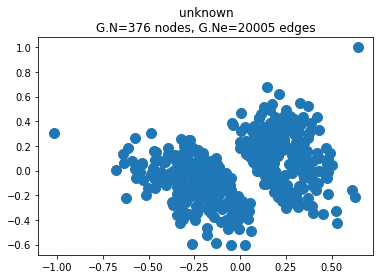

In [7]:
from pygsp import graphs, plotting
G_fd.set_coordinates()
G_fd.plot()

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


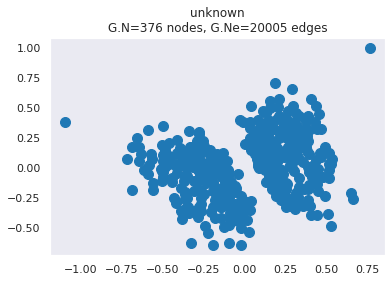

In [51]:
plotting.plot(G_fd)

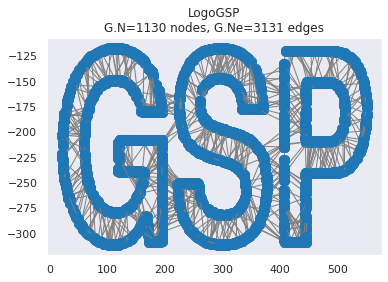

In [45]:

G = graphs.Logo()
plotting.plot(G)

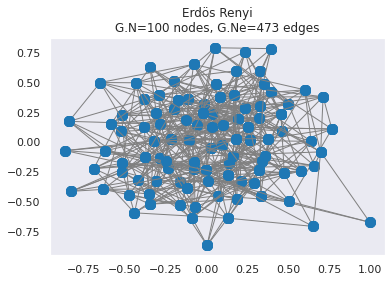

In [46]:
G = graphs.ErdosRenyi()
G.set_coordinates()
G.plot()